In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # Gets rid of the copy warning

# Create the dataframe
df = pd.read_csv('data/StarWars_data.csv', skiprows=1)  # Change file to read in here
df_display = df.copy()


### Data Cleaning and Feature Engineering

In [2]:
# Turn all numeric columns from formatted strings into floats
df['Adjusted Revenue'] = df['Adjusted Revenue'].apply(lambda x:  1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['US Box Office'] = df['US Box Office'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['International Revenue'] = df['International Revenue'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','').strip(' (est.)')))
df['Average Rating'] = df['Average Rating'].apply(lambda x: float(x.replace('%', '')))
df['Metacritic'] = df['Metacritic'].apply(lambda x: float(x.replace('%', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: float(x.replace(' / 10', '').replace(' (est.)', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: x*10)

In [3]:
# Fill in 'No Data' entries with mean for column
for index, row in df.iterrows():
    if df['Adjusted Revenue'][index] == 1:
        df['Adjusted Revenue'][index] = df['Adjusted Revenue'].mean()
    if df['US Box Office'][index] == 1:
        df['US Box Office'][index] = df['US Box Office'].mean()
    if df['International Revenue'][index] == 1:
        df['International Revenue'][index] = df['International Revenue'].mean()

In [4]:
# Use qcut() to put adjusted revenue and Average Rating into 3 groups 
df['Revenue Category'] = pd.qcut(df['Adjusted Revenue'], q=3, labels=False)
df['Rating Category'] = pd.qcut(df['Average Rating'], q=3, labels=False)

# Add Changes to df_display (the formatted for viewing dataframe)
df_display[[ 'Revenue Category', 'Rating Category']] = df[['Revenue Category', 'Rating Category']]

# Change qcut numbers to qualatative categories in df_display
bin = {
    0: 'Low',
    1: 'Average',
    2: 'High'
}
df_display['Rating Category'] = df_display['Rating Category'].map(bin)  # Both map() and apply() do the same thing with different syntax
df_display['Revenue Category'] = df_display['Revenue Category'].apply(lambda x: 'Low' if x == 0 else ('Average' if x == 1 else 'High'))

### New Column Explanation
* Revenue Category classifes a movies earnings as high, average or low
* Rating Categoy classifies movie ratings as high, average or low
* These new columns will be predicted to test accuracy

In [5]:
df_display

,Title,Year,Actor,US Box Office,International Revenue,Adjusted Revenue,Average Rating,IMDb Rating,Metacritic,Revenue Category,Rating Category
0,Star Wars: Episode I - The Phantom Menace,1999,Ewan McGregor,"$474,544,677","$1,027,082,707","$1,673,170,748",58.0%,6.5 / 10,51%,High,Low
1,Star Wars: Episode II - Attack of the Clones,2002,Hayden Christensen,"$310,676,740","$653,779,970","$986,302,856",59.5%,6.5 / 10,54%,Low,Low
2,Star Wars: Episode III - Revenge of the Sith,2005,Hayden Christensen,"$380,270,577","$868,390,560","$1,206,764,967",71.5%,7.5 / 10,68%,Average,Average
3,Star Wars: Episode IV - A New Hope,1977,Mark Hamill,"$460,998,507","$775,398,007","$3,472,657,081",88.0%,8.6 / 10,90%,High,High
4,Star Wars: Episode V - The Empire Strikes Back,1980,Mark Hamill,"$292,753,960","$538,375,067","$1,773,240,209",84.5%,8.7 / 10,82%,High,High
5,Star Wars: Episode VI - Return of the Jedi,1983,Mark Hamill,"$309,306,177","$475,106,177","$1,294,616,631",70.5%,8.3 / 10,58%,Average,Average
6,Star Wars: Episode VII - The Force Awakens,2015,Daisy Ridley,"$936,662,225","$2,068,455,677","$2,368,687,218",79.5%,7.9 / 10,80%,High,High
7,Star Wars: Episode VIII - The Last Jedi,2017,Daisy Ridley,"$620,181,382","$1,332,698,830","$1,475,701,601",77.0%,7.0 / 10,84%,Average,High
8,Star Wars: Episode IX - The Rise of Skywalker,2019,Daisy Ridley,"$515,202,542","$1,074,144,248","$1,140,096,789",59.5%,6.6 / 10,53%,Low,Low
9,Rogue One: A Star Wars Story,2016,Felicity Jones,"$532,177,324","$1,056,057,720","$1,194,225,272",71.5%,7.8 / 10,65%,Low,Average


### Display graphs of data to be predicted

The franchise has seen revenue decrease over time


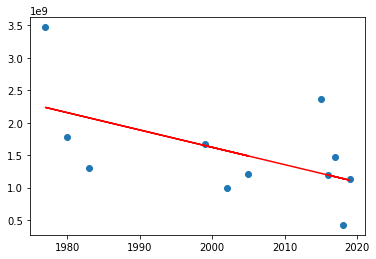

In [6]:
# Create the Revenue Plot
x = df['Year'].tolist()
y = df['Adjusted Revenue'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen revenue increase over time')
elif z[0] < -0.05:
    print('The franchise has seen revenue decrease over time')
else:
    print('The franchise has maintained a consistent revenue over time')
plt.show()

The franchise has seen review scores decline over time


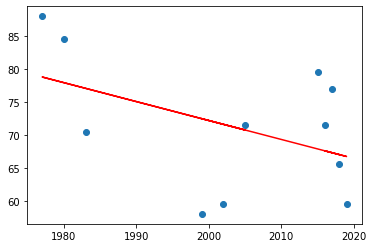

In [7]:
# Create the Average Review Score Plot
x = df['Year'].tolist()
y = df['Average Rating'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen review scores improve over time')
elif z[0] < -0.05:
    print('The franchise has seen review scores decline over time')
else:
    print('The franchise has maintained a consistent quality over time')
plt.show()

### Test Prediction Models Against Revenue Category

In [8]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rev = df.copy()
df_rev = pd.get_dummies(df_rev, columns=['Rating Category'], prefix = ['Rating'])
df_rev = df_rev.drop(['Title', 'Actor'], axis=1)

In [9]:
# Set X and Y for the training set
y = df_rev['Revenue Category']
df_rev = df_rev.drop(['Revenue Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(df_rev)

# Set the X for the training set
X = data_scaled

# Build the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [10]:
# Create the KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y_pred = knn.predict(X_test)

# Print the Accuracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 33.33%


In [11]:
# Create a DTC model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

# Make the Prediction for 'Revenue Category'
y_pred2 = clf.predict(X_test)

# Print the results
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 33.33%


In [12]:
# Predict Revenue for Hypothetical Next Movie

### Test Prediction Models Against Ratings Category

In [13]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rate = df.copy()
df_rate = pd.get_dummies(df_rate, columns=['Revenue Category'], prefix = ['Revenue'])
df_rate = df_rate.drop(['Title', 'Actor'], axis=1)

In [14]:
# Set Y for the training set
y2 = df_rate['Rating Category']
df_rate = df_rate.drop(['Rating Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler2 = StandardScaler()
data_scaled2 = std_scaler2.fit_transform(df_rate)

# Set the X for the training set
X2 = data_scaled2

# Build the training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=1)

In [15]:
# Create the KNN model
knn2 = KNeighborsClassifier()
knn2.fit(X2_train, y2_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y2_pred = knn2.predict(X2_test)

# Print the Accuracy score
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 16.67%


In [16]:
# Create a DTC model
clf2 = DecisionTreeClassifier(random_state=1)
clf2.fit(X2_train, y2_train)

# Make the Prediction for 'Revenue Category'
y2_pred2 = clf2.predict(X2_test)

# Print the results
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 16.67%


In [17]:
# Predict the Rating Category of a Hypothetical Next Movie

### Conclusion

In [18]:
# Show the predicted Revenue and Rating of the Hypothetical Next Film